In [38]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
import mailbox
import seaborn as sns

In [39]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Below, we import our mailbox in `.mbox` format, and declare the lists that we are going to use.

In [40]:
dmail = mailbox.mbox("Deliveroo.mbox")

In [41]:
merged_list = []
mails = []
restaurant = []
date = []
rtime = []
dtime = []
tip = []

In [42]:
def clean_list(dmail):
    """Extract only Order delivery history from mailbox"""
    for message in dmail:
        if message["subject"].split()[0] == 'Order':
            mails.append(message)
        else:
            continue 
    return mails

In [43]:
def clean_dtime(dtime):
    """Convert time strings to integer seconds"""
    lex = dtime.split()
    lex = [lex[0].replace("m", ""), lex[1].replace("s", "")]
    return int(lex[0])*60 + int(lex[1])

In [44]:
def parse_mails(mails):
    """Trims unnecessary text from email, giving us only the meat"""
    for message in mails:
        body = str(message.get_payload())
        restaurant.append(body.partition("Restaurant:")[2].partition("\r\nRest")[0].strip())
        date.append(str.split(body.partition("at:")[2].partition("\r\nDel")[0])[0])
        rtime.append(str.split(body.partition("at:")[2].partition("\r\nDel")[0])[1])
        bad_dtime = body.partition("Time:")[2].partition("\r\n\r\n")[0].strip()
        good_dtime = clean_dtime(bad_dtime)
        dtime.append(good_dtime)
        
        tip.append(float(body.partition("Tip:")[2].partition("\r\n\r\n")[0].strip()))
        
    return [date, rtime, restaurant, dtime, tip]

In [45]:
def clean_datetime(df):
    """Converts dates and times to datetime format"""
    dates = [datetime.datetime.strptime(date, "%Y-%m-%d") for date in df["Date"]]
    times = [datetime.datetime.strptime(tim, "%H:%M:%S").time() for tim in df["Time"]]
    df["Date"] = dates
    df["Time"] = times
    
    return df

In [46]:
def fix_times(df):
    """Convert times to be human-readable (minutes, seconds)"""
    dtimems = []
    for elem in df["Delivery Time (s)"]:
        m, s = divmod(elem, 60)
        dtimems.append(m + (round(s, -2) / 100))

    df["Delivery Time (s)"] = dtitems
    return df

In [47]:
mails = clean_list(dmail)
[date, rtime, restaurant, dtime, tip] = parse_mails(mails)
merged_list = list(zip(*[date, rtime, restaurant, dtime, tip]))

In [48]:
df = pd.DataFrame(merged_list, columns=['Date', 'Time', 'Restaurant', 'Delivery Time (s)', 'Tip'])
df = df[df["Delivery Time (s)"] < 3000]
df = clean_datetime(df)

In [49]:
rest_day = df.groupby(["Restaurant"]).sum()
tip_pos = rest_day[rest_day["Tip"] != 0].count() / rest_day.count()
print("{0:.4f}% chance of receiving credit card tip".format(tip_pos["Tip"] * 100))

58.2278% chance of receiving credit card tip


In [50]:
df["Time"] = [times.replace(second = 0) for times in df["Time"]]
df["Time"] = [times.replace(minute = 0) for times in df["Time"]]

In [51]:
timegrp = df.groupby(["Time"])

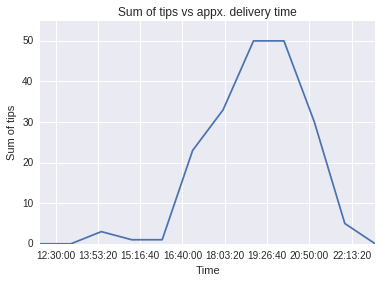

In [52]:
time_tip_plot = timegrp.sum()["Tip"].plot(title = "Sum of tips vs appx. delivery time", ylim = (0, 55))
time_tip_plot.set_ylabel("Sum of tips")

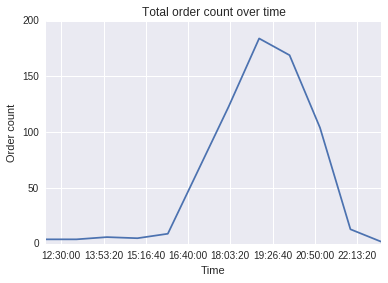

In [53]:
time_tip_count_plot = (timegrp["Tip"].count().plot(title = "Total order count over time"))
time_tip_count_plot.set_ylabel("Order count")

In [54]:
dategrp = df.groupby(["Date"])
dgmean = dategrp.mean()

In [55]:
timeout = [dategrp["Time"].max()[i].hour for i in range(len(dategrp["Time"]))]
timein = [dategrp["Time"].min()[i].hour for i in range(len(dategrp["Time"]))]
hrs_worked = sum([(t_out - t_in) for t_out, t_in in zip(timeout, timein)])

In [56]:
commis_earn = df["Time"].count() * 1
tip_earn = timegrp["Tip"].sum().sum()
total_earn = hrs_worked * 6 + commis_earn + tip_earn

In [57]:
print("{} appx. hours worked at $6 per hour\n{} deliveries at £1 per delivery\n£{} credit card tips\n£{} total".format(hrs_worked, commis_earn, tip_earn, total_earn))

316 appx. hours worked at $6 per hour
689 deliveries at £1 per delivery
£196.0 credit card tips
£2781.0 total


In [58]:
#dgmean = fix_times(dgmean)

In [59]:
dgmean

,Delivery Time (s),Tip
Date,,
2016-01-28,683.000000,0.166667
2016-01-29,784.428571,0.000000
2016-01-31,754.333333,0.222222
2016-02-05,750.333333,0.666667
2016-02-06,685.222222,0.888889
2016-02-07,863.272727,0.000000
2016-02-09,771.000000,0.571429
2016-02-10,778.166667,0.166667
2016-02-12,634.500000,0.000000


In [61]:
dtimems = []
for elem in dgmean["Delivery Time (s)"]:
    m, s = divmod(elem, 60)
    dtimems.append(m + (round(s, -2) / 100))

dgmean["Delivery Time (s)"] = dtimems

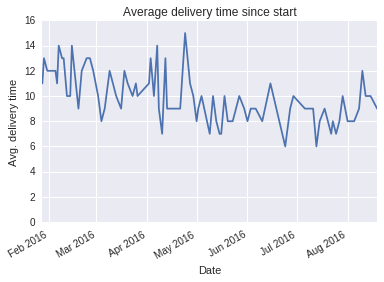

In [62]:
month_dtime_plot = dgmean["Delivery Time (s)"].plot(title = "Average delivery time since start", ylim = (0, 16))
month_dtime_plot.set_ylabel("Avg. delivery time")

/home/ruski/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


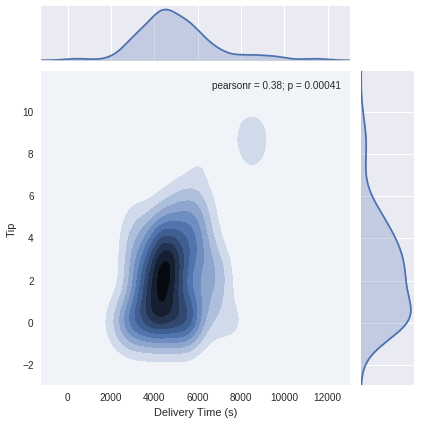

In [66]:
dgsum = dategrp.sum()
sns.jointplot(x = dgsum["Delivery Time (s)"], y = dgsum["Tip"], kind = "kde")

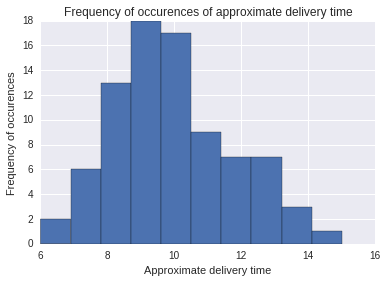

In [64]:
del_time_freq_plot = dgmean["Delivery Time (s)"].plot(title = "Frequency of occurences of approximate delivery time", kind = 'hist')
del_time_freq_plot.set_ylabel("Frequency of occurences")
del_time_freq_plot.set_xlabel("Approximate delivery time")

In [65]:
from sklearn import tree

data = [df["Tip"], df["Delivery Time (s)"]]
target = range(2)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(data, target)

clf.predict(data)

array([0, 1])